In [1]:
# Demonstrates generation of a PCE for a simple model


In [2]:
from itertools import chain, combinations

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation

from UncertainSCI.distributions import BetaDistribution
from UncertainSCI.model_examples import KLE_exponential_covariance_1d, \
                                        laplace_ode, laplace_grid_x
from UncertainSCI.indexing import TotalDegreeSet
from UncertainSCI.pce import PolynomialChaosExpansion
from UncertainSCI.utils.version import version_lessthan

In [ ]:
animate = True

In [3]:
"""
3 things must be specified:
- The physical model
- A parameter distribution
- The initial expressivity of the PCE (polynomial space)
"""



'\n3 things must be specified:\n- The physical model\n- A parameter distribution\n- The initial expressivity of the PCE (polynomial space)\n'

In [4]:
# Number of parameters
dimension = 2

In [5]:
"""
Define model:

  -d/dx a(x,p) d/dx u(x,p) = f(x)

over x in [-1,1], where a(x,p) is a parameterized diffusion model:

  a(x,p) = abar(x) + sum_{j=1}^d lambda_j p_j phi_j(x),

where d = dimension, (lambda_j, phi_j) are eigenpairs of the exponential
covariance kernel,

  K(s,t) = exp(-|s-t|/a).

The p_j are modeled as iid random variables.
"""


'\nDefine model:\n\n  -d/dx a(x,p) d/dx u(x,p) = f(x)\n\nover x in [-1,1], where a(x,p) is a parameterized diffusion model:\n\n  a(x,p) = abar(x) + sum_{j=1}^d lambda_j p_j phi_j(x),\n\nwhere d = dimension, (lambda_j, phi_j) are eigenpairs of the exponential\ncovariance kernel,\n\n  K(s,t) = exp(-|s-t|/a).\n\nThe p_j are modeled as iid random variables.\n'

In [6]:
# Define diffusion coefficient
a = 1.
b = 1.  # Interval is [-b,b]
abar = lambda x: 1*np.ones(np.shape(x))
KLE = KLE_exponential_covariance_1d(dimension, a, b, abar)

diffusion = lambda x, p: KLE(x, p)

N = int(1e2)  # Number of spatial degrees of freedom of model
left = -1.
right = 1.
x = laplace_grid_x(left, right, N)

model = laplace_ode(left=left, right=right, N=N, diffusion=diffusion)


In [7]:
# Specifies 1D distribution on [0,1] (alpha=beta=1 ---> uniform)
alpha = 1.
beta = 1.
dist = BetaDistribution(alpha=alpha, beta=beta, dim=dimension)

In [8]:
# Expressivity setup
order = 0
index_set = TotalDegreeSet(dim=dimension, order=order)
starting_indices = index_set.get_indices()

In [9]:
# Building the PCE
pce = PolynomialChaosExpansion(index_set, dist)
pce.build(model=model)
Nstarting_samples = pce.samples.shape[0]
initial_accuracy = pce.accuracy_metrics.copy()

In [10]:
# pce.adapt_robustness(max_new_samples=50)
residuals, loocvs, added_indices, added_samples = pce.adapt_expressivity(max_new_samples=100, add_rule=3)


new indices:      1,   new samples:      4
old residual: 1.910e-01,  old loocv: 1.219e-01
new residual: 9.144e-03,  new loocv: 2.694e-02
new indices:      1,   new samples:      4
old residual: 9.144e-03,  old loocv: 2.694e-02
new residual: 2.219e-03,  new loocv: 1.025e-02
new indices:      1,   new samples:      4
old residual: 2.219e-03,  old loocv: 1.025e-02
new residual: 2.732e-03,  new loocv: 1.036e-02
new indices:      1,   new samples:      4
old residual: 2.732e-03,  old loocv: 1.036e-02
new residual: 6.582e-04,  new loocv: 5.016e-03
new indices:      1,   new samples:      4
old residual: 6.582e-04,  old loocv: 5.016e-03
new residual: 1.117e-04,  new loocv: 2.190e-03
new indices:      1,   new samples:      4
old residual: 1.117e-04,  old loocv: 2.190e-03
new residual: 6.090e-05,  new loocv: 1.543e-03
new indices:      1,   new samples:      4
old residual: 6.090e-05,  old loocv: 1.543e-03
new residual: 5.188e-05,  new loocv: 1.384e-03
new indices:      1,   new samples:      

In [11]:
# # Postprocess PCE: mean, stdev, sensitivities, quantiles
mean = pce.mean()
stdev = pce.stdev()


In [12]:
# Set of subsets of [0, 1, ..., dimension-1] with at most 3 components
variable_interactions = list(chain.from_iterable(combinations(range(dimension), r) for r in range(1, 3+1)))


In [13]:
# "Total sensitivity" is a non-partitive relative sensitivity measure per
# parameter.
total_sensitivity = pce.total_sensitivity()


In [14]:
# "Global sensitivity" is a partitive relative sensitivity measure per set of
# parameters.
global_sensitivity = pce.global_sensitivity(variable_interactions)

In [15]:
Q = 3  # Number of quantile bands to plot
dq = 0.5/(Q+1)
q_lower = np.arange(dq, 0.5-1e-7, dq)[::-1]
q_upper = np.arange(0.5 + dq, 1.0-1e-7, dq)
quantile_levels = np.append(np.concatenate((q_lower, q_upper)), 0.5)

quantiles = pce.quantile(quantile_levels, M=int(2e3))
median = quantiles[-1, :]


In [16]:
# # For comparison: Monte Carlo statistics
M = 1000  # Generate MC samples
p_phys = dist.MC_samples(M)
output = np.zeros([M, N])

for j in range(M):
    output[j, :] = model(p_phys[j, :])

MC_mean = np.mean(output, axis=0)
MC_stdev = np.std(output, axis=0)
if version_lessthan(np,'1.15'):
    from scipy.stats.mstats import mquantiles
    MC_quantiles = mquantiles(output, quantile_levels, axis=0)
else:
    MC_quantiles = np.quantile(output, quantile_levels, axis=0)
MC_median = quantiles[-1, :]

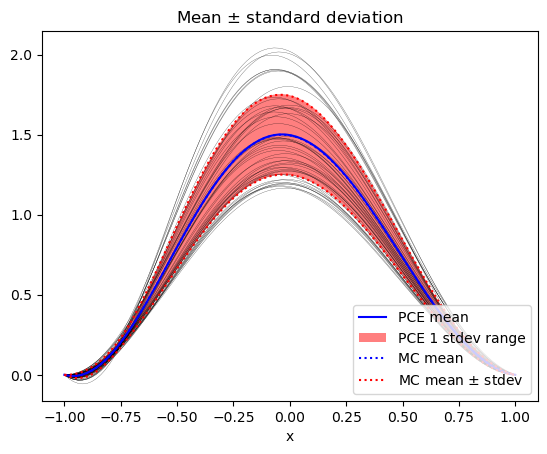

In [17]:
# # Visualization
V = 50  # Number of MC samples to visualize

# mean +/- stdev plot
plt.plot(x, output[:V, :].T, 'k', alpha=0.8, linewidth=0.2)
plt.plot(x, mean, 'b', label='PCE mean')
plt.fill_between(x, mean-stdev, mean+stdev, interpolate=True, facecolor='red',
                 alpha=0.5, label='PCE 1 stdev range')

plt.plot(x, MC_mean, 'b:', label='MC mean')
plt.plot(x, MC_mean+MC_stdev, 'r:', label='MC mean $\\pm$ stdev')
plt.plot(x, MC_mean-MC_stdev, 'r:')

plt.xlabel('x')
plt.title('Mean $\\pm$ standard deviation')

plt.legend(loc='lower right')


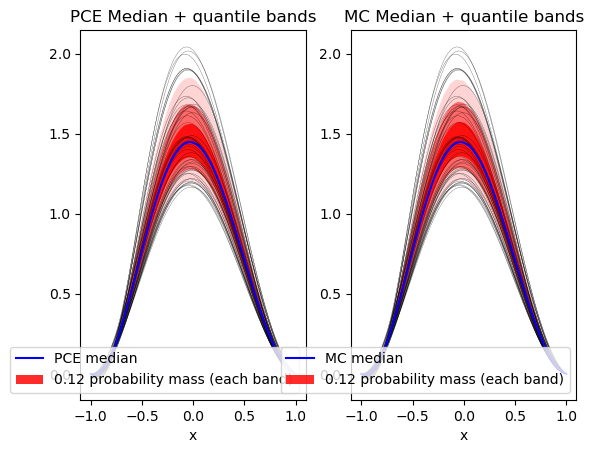

In [18]:
# quantile plot
plt.figure()

plt.subplot(121)
plt.plot(x, output[:V, :].T, 'k', alpha=0.8, linewidth=0.2)
plt.plot(x, median, 'b', label='PCE median')

band_mass = 1/(2*(Q+1))

for ind in range(Q):
    alpha = (Q-ind) * 1/Q - (1/(2*Q))
    if ind == 0:
        plt.fill_between(x, quantiles[ind, :], quantiles[Q+ind, :],
                         interpolate=True, facecolor='red', alpha=alpha,
                         label='{0:1.2f} probability mass (each band)'.format(band_mass))
    else:
        plt.fill_between(x, quantiles[ind, :], quantiles[Q+ind, :],
                         interpolate=True, facecolor='red', alpha=alpha)

plt.title('PCE Median + quantile bands')
plt.xlabel('x')
plt.legend(loc='lower right')

plt.subplot(122)
plt.plot(x, output[:V, :].T, 'k', alpha=0.8, linewidth=0.2)
plt.plot(x, MC_median, 'b', label='MC median')

for ind in range(Q):
    alpha = (Q-ind) * 1/Q - (1/(2*Q))
    if ind == 0:
        plt.fill_between(x, MC_quantiles[ind, :], MC_quantiles[Q+ind, :],
                         interpolate=True, facecolor='red',
                         alpha=alpha,
                         label='{0:1.2f} probability mass (each band)'
                         .format(band_mass))
    else:
        plt.fill_between(x, MC_quantiles[ind, :], MC_quantiles[Q+ind, :],
                         interpolate=True, facecolor='red', alpha=alpha)

plt.title('MC Median + quantile bands')
plt.xlabel('x')
plt.legend(loc='lower right')


Text(0.5, 1.0, 'Sensitivity due to variable interactions')

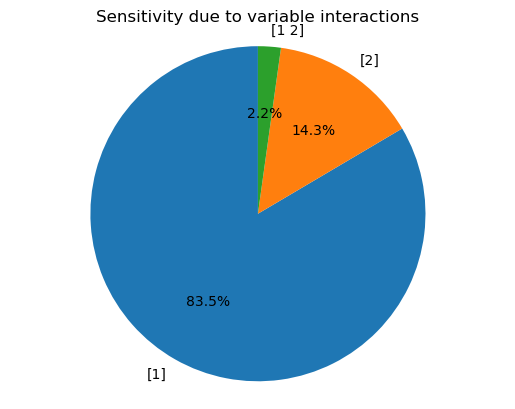

In [19]:
# Sensitivity pie chart, averaged over all model degrees of freedom
average_global_SI = np.sum(global_sensitivity, axis=1)/N

labels = ['[' + ' '.join(str(elem) for elem in [i+1 for i in item]) +
          ']' for item in variable_interactions]
_, ax = plt.subplots()
ax.pie(average_global_SI*100, labels=labels, autopct='%1.1f%%',
       startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sensitivity due to variable interactions')



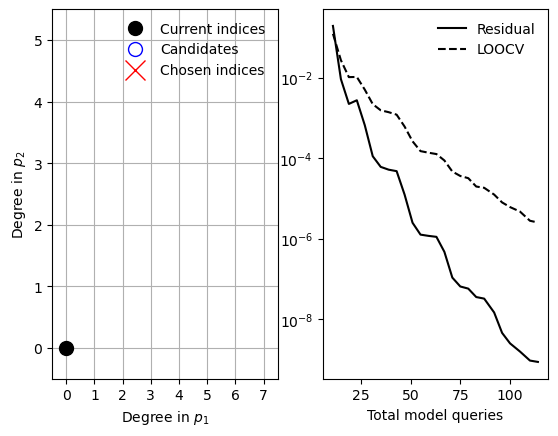

In [20]:
# Index set plot
if dimension == 2:
    fig = plt.figure()

    plt.subplot(121)

    current_inds = plt.plot(starting_indices[:, 0], starting_indices[:, 1],
                            'k.', markersize=20, label='Current indices')[0]
    rmargin = plt.plot([], [], 'bo', markersize=10, fillstyle='none',
                       label='Candidates')[0]
    future_inds = plt.plot([], [], 'rx', markersize=15,
                           label='Chosen indices')[0]

    plt.legend(frameon=False)

    indices = pce.index_set.get_indices()
    maxx, maxy = indices[:, 0].max(), indices[:, 1].max()
    plt.axis([-0.5, maxx+1.5, -0.5, maxy+1.5])
    plt.gca().set_yticks(range(maxy+2), minor=False)
    plt.gca().set_xticks(range(maxx+2), minor=False)
    plt.grid()
    plt.xlabel('Degree in $p_1$')
    plt.ylabel('Degree in $p_2$')

    plt.subplot(122)
    added_samples.insert(0, Nstarting_samples)
    Nsamples = np.cumsum(added_samples)
    plt.semilogy(Nsamples, residuals, 'k-', label='Residual')
    plt.semilogy(Nsamples, loocvs, 'k--', label='LOOCV')
    current_accuracy = plt.plot([], [], 'rx', markersize=15)[0]
    plt.xlabel('Total model queries')
    plt.legend(frameon=False)

    def animation_init():
        return current_inds, future_inds, rmargin, current_accuracy

    def animation_update(i):
        index_set = TotalDegreeSet(dim=dimension, order=order)
        for q in range(i):
            index_set.augment(added_indices[q])

        current_set = index_set.get_indices()
        reduced_margin = index_set.get_reduced_margin()

        current_inds.set_data(current_set[:, 0], current_set[:, 1])
        rmargin.set_data(reduced_margin[:, 0], reduced_margin[:, 1])
        future_inds.set_data(added_indices[i][:, 0], added_indices[i][:, 1])
        current_accuracy.set_data([Nsamples[i+1], Nsamples[i+1]],
                                  [residuals[i+1], loocvs[i+1]])

        return current_inds, future_inds, rmargin, current_accuracy

    ani = animation.FuncAnimation(fig, animation_update,
                                  np.arange(0, len(added_indices)),
                                  interval=3000, blit=True,
                                  init_func=animation_init, repeat_delay=5000)

else:
    plt.figure()
    added_samples.insert(0, Nstarting_samples)
    Nsamples = np.cumsum(added_samples)
    plt.semilogy(Nsamples, residuals, 'k-', label='Residual')
    plt.semilogy(Nsamples, loocvs, 'k--', label='LOOCV')
    plt.xlabel('Total model queries')
    plt.legend(frameon=False)

    